In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
import string 
import re
import plotly.express as px
import nltk
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from collections import Counter


In [3]:
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

In [4]:
fake_news['output']=0
true_news['output']=1

In [5]:
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [6]:
frames = [fake_news, true_news]
news = pd.concat(frames)
news

subject               date  \
0           News  December 31, 2017   
1           News  December 31, 2017   
2           News  December 30, 2017   
3           News  December 29, 2017   
4           News  December 25, 2017   
...          ...                ...   
21412  worldnews   August 22, 2017    
21413  worldnews   August 22, 2017    
21414  worldnews   August 22, 2017    
21415  worldnews   August 22, 2017    
21416  worldnews   August 22, 2017    

                                                    news  output  
0       Donald Trump Sends Out Embarrassing New Year’...       0  
1       Drunk Bragging Trump Staffer Started Russian ...       0  
2       Sheriff David Clarke Becomes An Internet Joke...       0  
3       Trump Is So Obsessed He Even Has Obama’s Name...       0  
4       Pope Francis Just Called Out Donald Trump Dur...       0  
...                                                  ...     ...  
21412  'Fully committed' NATO backs new U.S. approach...       1  
21413  LexisNexis withdrew two products from Chinese ...       1  
21414  Minsk cultural hub becomes haven from authorit...       1  
21415  Vatican upbeat on possibility of Pope Francis ...       1  
21416  Indonesia to buy $1.14 billion worth of Russia...       1  

[44898 rows x 4 columns]

### Text Processing

In [7]:
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

In [8]:
clean_news=news.copy()

In [9]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

subject               date  \
0    News  December 31, 2017   
1    News  December 31, 2017   
2    News  December 30, 2017   
3    News  December 29, 2017   
4    News  December 25, 2017   

                                                news  output  
0   donald trump sends out embarrassing new year’...       0  
1   drunk bragging trump staffer started russian ...       0  
2   sheriff david clarke becomes an internet joke...       0  
3   trump is so obsessed he even has obama’s name...       0  
4   pope francis just called out donald trump dur...       0

In [11]:
#Stopwords removal
stop = spacy.lang.en.stop_words.STOP_WORDS
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

subject               date  \
0    News  December 31, 2017   
1    News  December 31, 2017   
2    News  December 30, 2017   
3    News  December 29, 2017   
4    News  December 25, 2017   

                                                news  output  
0  donald trump sends embarrassing new year’s eve...       0  
1  drunk bragging trump staffer started russian c...       0  
2  sheriff david clarke internet joke threatening...       0  
3  trump obsessed obama’s coded website imageson ...       0  
4  pope francis called donald trump christmas spe...       0

### Visulization

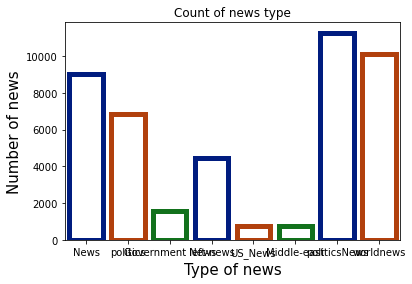

In [12]:
#Frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

More political news than any other news followed by world news.
Some repeated class names

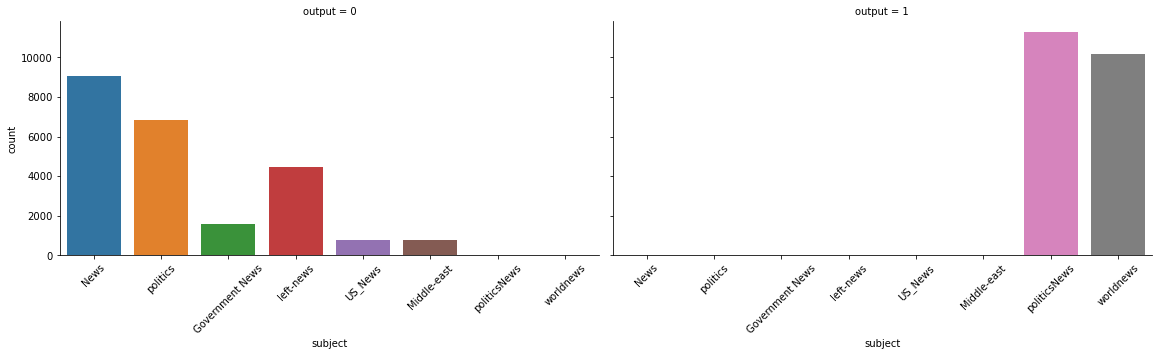

In [13]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

g.set_xticklabels(rotation=45)

Highly Biased dataset

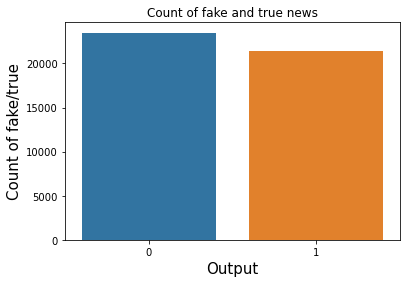

In [14]:
ax=sns.countplot(x="output", data=clean_news)

ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

### New features from dataset

C:\Users\Ritik\anaconda3\envs\Ritik\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ritik\anaconda3\envs\Ritik\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ritik\anaconda3\envs\Ritik\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

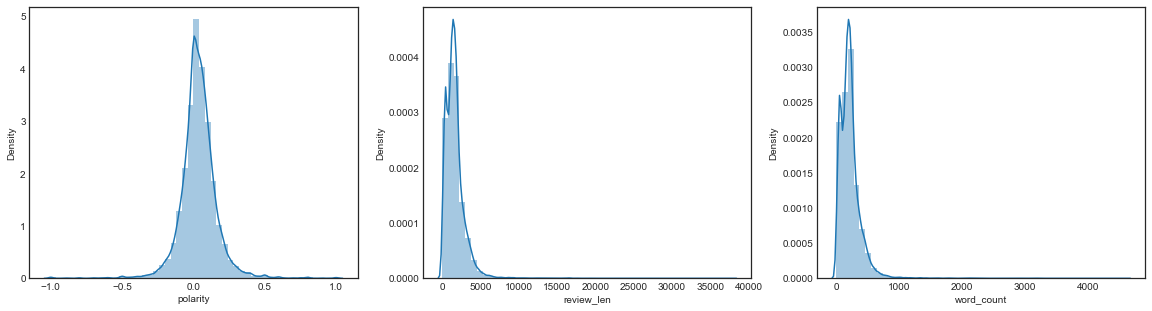

In [15]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

N gram analysis

Top 1 word in news

In [16]:
#Top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(clean_news['news'], 20)

for word, freq in common_words:
    print(word, freq)

df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    # kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 140400
said 130258
president 53189
people 41718
state 33190
new 31799
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
white 23823
told 23541
united 23456
like 22472
campaign 21768
news 20998


Top 2 words

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(clean_news['news'], 20)

for word, freq in common_words:
    print(word, freq)
    
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

donald trump 25061
united states 18394
white house 15486
hillary clinton 9502
new york 8110
north korea 7053
president donald 6932
barack obama 5603
trump said 4963
prime minister 4753
president trump 4665
supreme court 4595
said statement 4439
fox news 4074
president obama 4068
islamic state 4014
national security 3858
secretary state 3830
president barack 3789
trump administration 3774


In [18]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(clean_news['news'], 20)

for word, freq in common_words:
    print(word, freq)

df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')


president donald trump 6808
president barack obama 3735
new york times 2034
donald trump realdonaldtrump 1790
reuters president donald 1476
black lives matter 1433
president united states 1096
white house said 1050
presidentelect donald trump 1043
new york city 1006
president vladimir putin 955
news century wire 951
national security adviser 898
affordable care act 868
director james comey 860
speaker paul ryan 851
fbi director james 778
state rex tillerson 775
secretary state rex 765
russian president vladimir 745


### Wordcloud

For Fake News


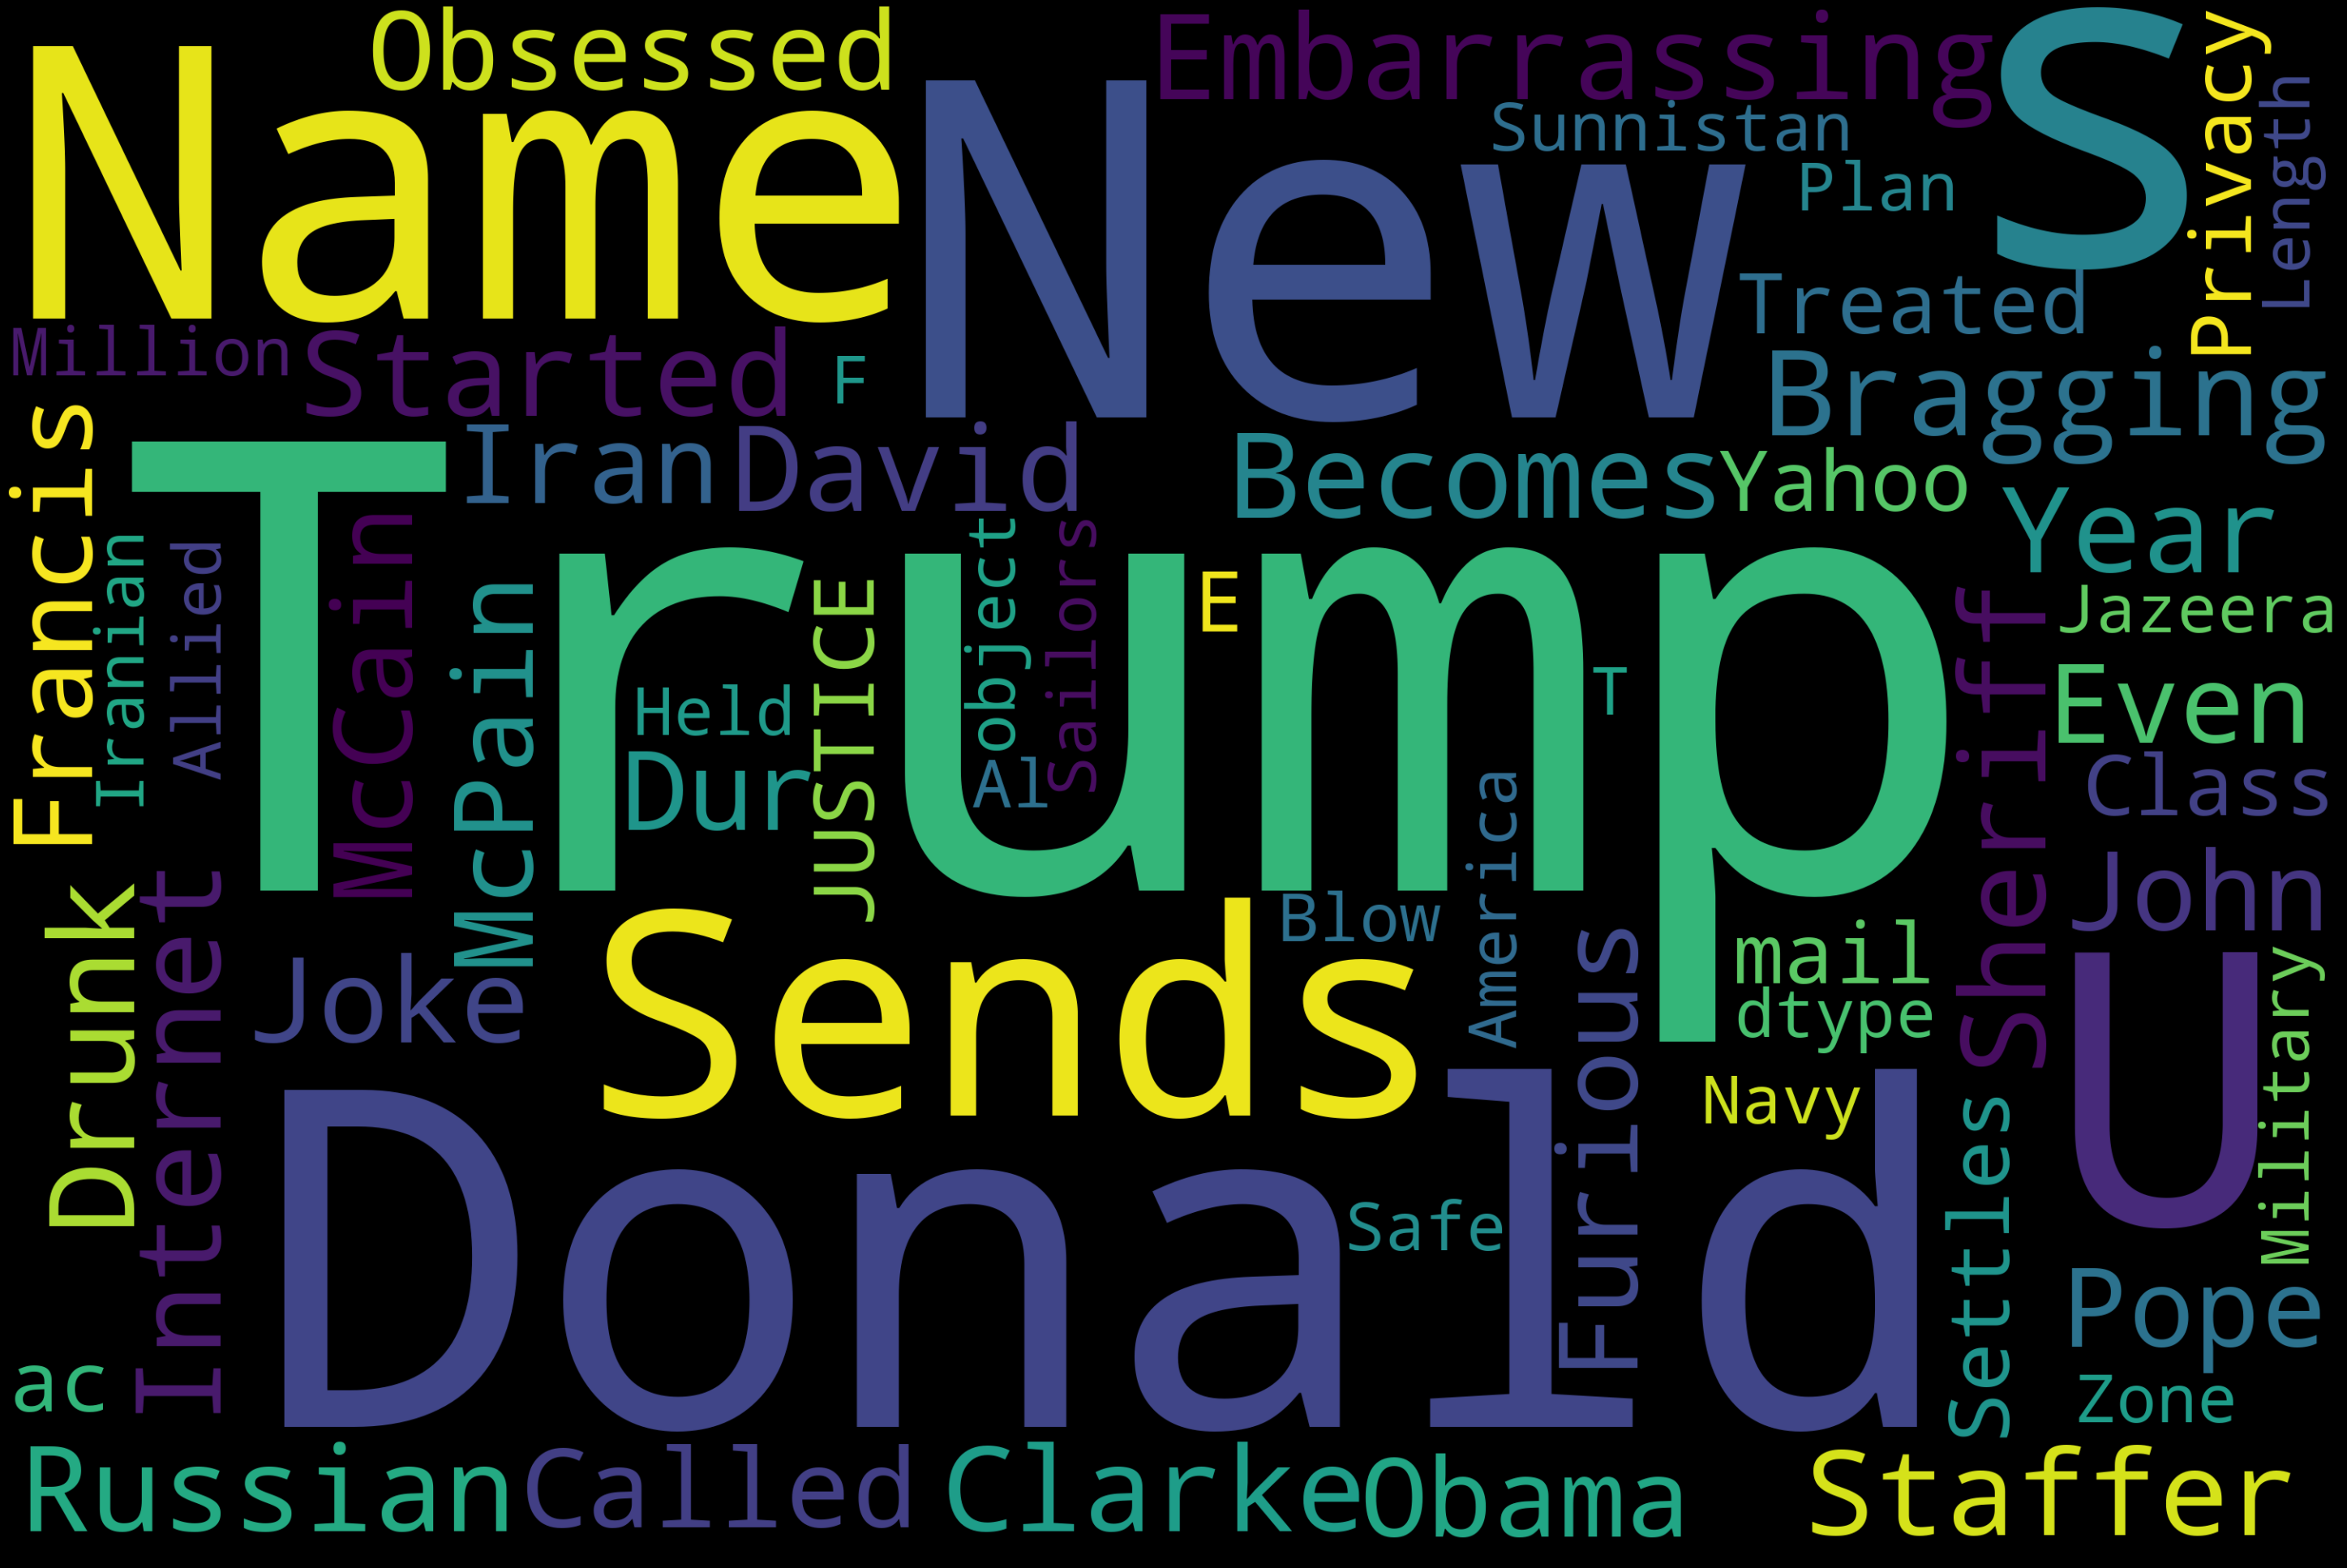

In [19]:
print('For Fake News')
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For True News


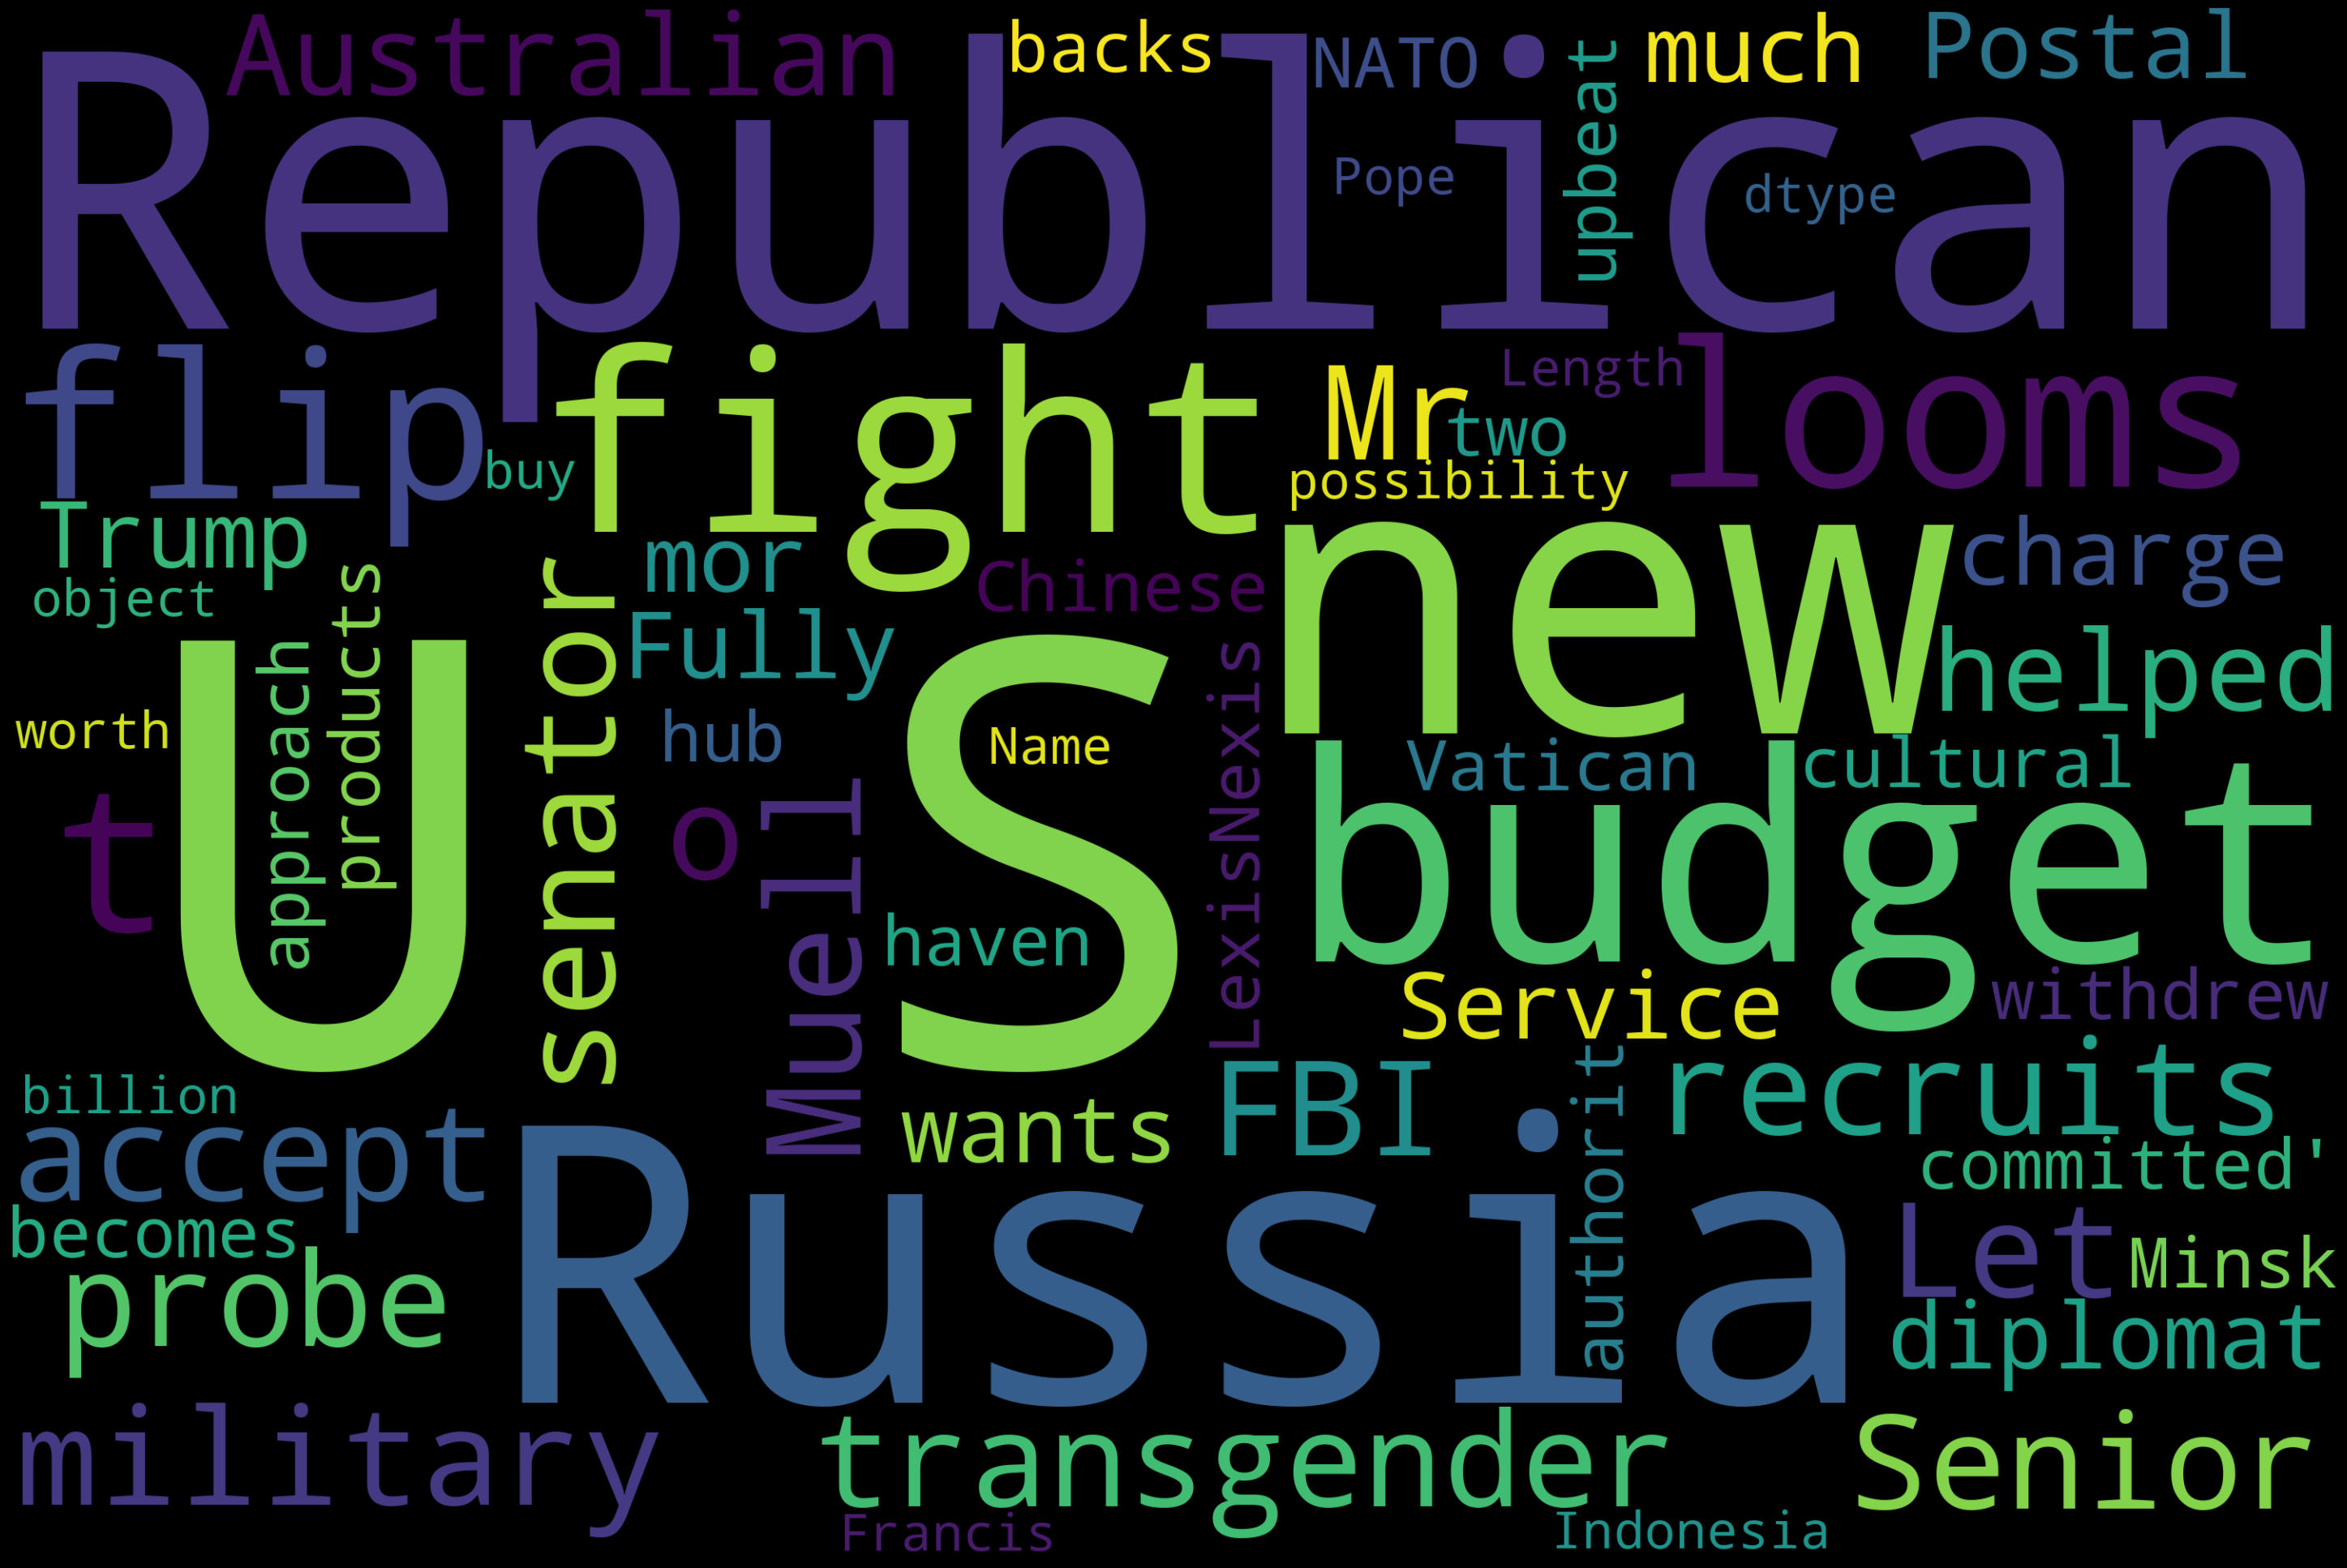

In [20]:
print('For True News')
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Stemming

In [21]:
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

news
0  donald trump sends embarrassing new year’s eve...
1  drunk bragging trump staffer started russian c...
2  sheriff david clarke internet joke threatening...
3  trump obsessed obama’s coded website imageson ...
4  pope francis called donald trump christmas spe...

In [22]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [23]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon papadopoulo covfef boy trump administr alleg larger role damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt month elect known aid set meet world leader trump team trump ran mere coffe boyin papadopoulo reveal australian diplomat alexand downer russian offici shop possibl dirt thendemocrat presidenti nomine hillari clinton exactli mr papadopoulo said night kensington wine room australian alexand downer unclear report state month later leak democrat email began appear onlin australian offici pass inform mr papadopoulo american counterpart accord

# USING LSTM

In [24]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [25]:
voc_size=10000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

### PAdding Embedded Documents
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our LSTM model, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary. 

In [26]:
sent_length=5000
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 5469 8385  162]
 [   0    0    0 ... 4796 5994  162]
 [   0    0    0 ... 2807 6600  162]
 ...
 [   0    0    0 ... 7708 5112 8521]
 [   0    0    0 ... 6541 4371 3436]
 [   0    0    0 ... 4153 6146 8915]]


In [27]:
embedded_docs[1]

array([   0,    0,    0, ..., 4796, 5994,  162])

In [28]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) 
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 40)          400000    
_________________________________________________________________
dropout (Dropout)            (None, 5000, 40)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
len(embedded_docs)

44898

In [30]:
y=clean_news['output']

In [31]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_final.shape,y_final.shape

((44898, 5000), (44898,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
  4/471 [..............................] - ETA: 4:59:31 - loss: 0.6914 - accuracy: 0.5547

In [ ]:
y_pred=model.predict_classes(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
print(classification_report(y_test,y_pred))

# Using Bi-Directional LSTM

In [ ]:
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

In [ ]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

In [ ]:
y_pred1=model1.predict_classes(X_test)

cm = metrics.confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
accuracy_score(y_test,y_pred1)

In [ ]:
print(classification_report(y_test,y_pred1))

From the classification report we can see the accuracy value is nearly around 98%. We have to concentrate on precision score and it is 98%